# A beginner's guide to PySDDR

We start by importing the sddr module and other required libraries

In [1]:
from sddr import Sddr
import torch.nn as nn
import pandas as pd
import torch.optim as optim

# First use case: A Simple GAM Poisson Distribution

### User inputs 

First the user defines the data to be used:

In [2]:
# define data location
data_path = '../data/simple_gam/X.csv'
target_path = '../data/simple_gam/Y.csv'
# read data into pandas dataframe
data = pd.read_csv(data_path,delimiter=';')
target = pd.read_csv(target_path)
# split the data into train and test to use later for predictions
train_data = data.iloc[:800]
train_target = target.iloc[:800]
test_data = data.iloc[800:]

Next the distribution, formulas and training parameters are defined:

In [3]:
# define output directory
output_dir = './outputs'

# define distribution and the formula for the distibutional parameter
distribution  = 'Poisson'
formulas = {'rate': '~1+spline(x1, bs="bs",df=9)+spline(x2, bs="bs",df=9)+d1(x1)+d2(x2)'}

# define the deep neural networks' architectures and output shapes used in the above formula
deep_models_dict = {
'd1': {
    'model': nn.Sequential(nn.Linear(1,15)),
    'output_shape': 15},
'd2': {
    'model': nn.Sequential(nn.Linear(1,3),nn.ReLU(), nn.Linear(3,8)),
    'output_shape': 8}
}

# define your training hyperparameters
train_parameters = {
    'batch_size': 1000,
    'epochs': 200,
    'degrees_of_freedom': {'rate': 6},
    'optimizer' : optim.RMSprop
    }

Alternatively these parameters can be defined in a config file (for example see config.yaml)

### Initialization

The sddr instance is initialized with the parameters given by the user in the previous step

In [4]:
sddr = Sddr(distribution=distribution,
            formulas=formulas,
            deep_models_dict=deep_models_dict,
            train_parameters=train_parameters,
            output_dir=output_dir)

Using device:  cpu


Alternatively, the initialization can be done with a config file:

In [ ]:
'''
import yaml

# get config
def get_config(config):
    with open(config, 'r') as stream:
        return yaml.safe_load(stream)

#load config file
config = get_config('config.yaml') 
# initialize sddr instance
sddr = Sddr(config=config)
'''

Since this will load all data from a file without splitting into train and test as we have done above, we have commented this part out for now. Also note that the config.yaml option currently only works if the deep networks are defined as in the ```config.yaml``` (directly with modules from torch.nn given as strings) and does not accept local scripts or torch models

### Training

The sddr network is trained with the data defined above and the loss curve is plotted. Note that in this example we all have tabular data so structured_data is not given.

Beginning training ...
Train Epoch: 0 	 Loss: 147.413406
Train Epoch: 20 	 Loss: 80.032867
Train Epoch: 40 	 Loss: 50.537796
Train Epoch: 60 	 Loss: 32.250233
Train Epoch: 80 	 Loss: 21.297529
Train Epoch: 100 	 Loss: 15.516757
Train Epoch: 120 	 Loss: 12.674661
Train Epoch: 140 	 Loss: 11.188475
Train Epoch: 160 	 Loss: 10.323308
Train Epoch: 180 	 Loss: 9.784346


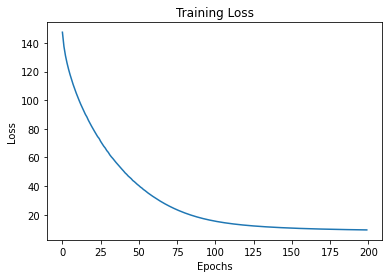

In [5]:
sddr.train(structured_data=train_data,
           target=train_target,
           plot=True)

### Visualizing the partial effects

The partial effects are computed by: partial effect = smooth_features * coefs (weights)
In other words the smoothing terms are multiplied witht the weights of the Structured Head. We use the partial effects to interpret whether our model has learned correctly.

In the case below the model is a generalized additive model with two splines (one has a quadratic effect, one has only a linear effect), while target is assumed to come from a Poisson distribution. The quadratic and linear effects are confirmed when plotting the partial effects below.

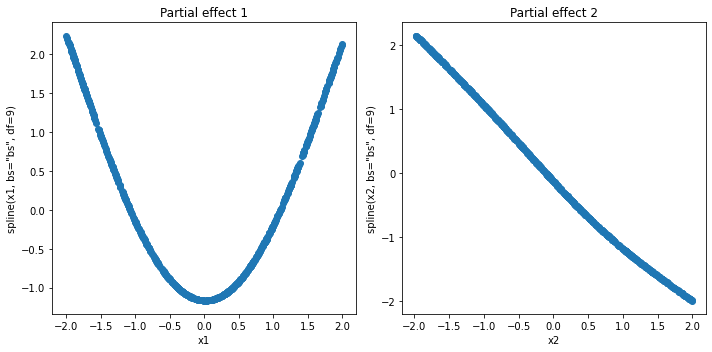

In [6]:
partial_effects = sddr.eval('rate')

### Save, load and resume

Next, we save the trained model. Along with the model's weights the optimizer current state will be saved, along with the number of epochs we trained for and the final loss function

In [7]:
sddr.save('model_gam.pth')

/Users/christina.bukas/Documents/AI_projects/code/reimplementations/PySDDR/sddr/sddr.py:285: UserWarning: Please note that the metadata for the structured input has not been saved. If you want to load the model and use
        it on new data you will need to also give the structured data used for training as input to the load function.
  it on new data you will need to also give the structured data used for training as input to the load function.""")


To resume trained at a later state we need to again initialize an sddr instance, load the model previously trained model and resume training. Note that the ```resume=True``` flag needs to be set here when calling ```sddr.train```. Also note that here ```epochs``` is set to 300, while previously the network was trained for ```200``` epochs. This means that the model during resume will train for 300-200=100 epochs more

In [8]:
train_parameters['epochs'] = 300
sddr_resume = Sddr(output_dir=output_dir,
            distribution=distribution,
            formulas=formulas,
            deep_models_dict=deep_models_dict,
            train_parameters=train_parameters)
sddr_resume.load('./outputs/model_gam.pth', train_data)
sddr_resume.train(target=train_target, structured_data=train_data, resume=True)
loss_resume = sddr_resume.epoch_loss

/Users/christina.bukas/opt/anaconda3/envs/dev_pysddr/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using device:  cpu
Loaded model ./outputs/model_gam.pth at epoch 200 with a loss 9.4499
Beginning training ...
Train Epoch: 210 	 Loss: 9.308732
Train Epoch: 240 	 Loss: 9.065203
Train Epoch: 270 	 Loss: 8.903995


### Predicting

A trained model can also be used for predictions on unseen data. Note that when loading the model the structured training data is required to compute the knots of the basis functions used for the smoothing terms

In [9]:
# initialize
pred_sddr = Sddr(distribution=distribution,
                formulas=formulas,
                deep_models_dict=deep_models_dict,
                train_parameters=train_parameters,
                output_dir=output_dir)
# load trained model
pred_sddr.load('./outputs/model_gam.pth', train_data)
# make predictions
_, partial_effects_loaded = pred_sddr.predict(test_data, plot=True)

/Users/christina.bukas/opt/anaconda3/envs/dev_pysddr/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using device:  cpu
Loaded model ./outputs/model_gam.pth at epoch 200 with a loss 9.4499


Exception: Data should stay within the range of the training data. Please try clipping or manually set knots.

Note the above error. This occurs because the test data is outside the range of the training data. The framework can deal with this problem by allowing clipping of the test data. For clipping the corresponding parameter needs to be set to ```True``` when calling ```predict()```

/Users/christina.bukas/opt/anaconda3/envs/dev_pysddr/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


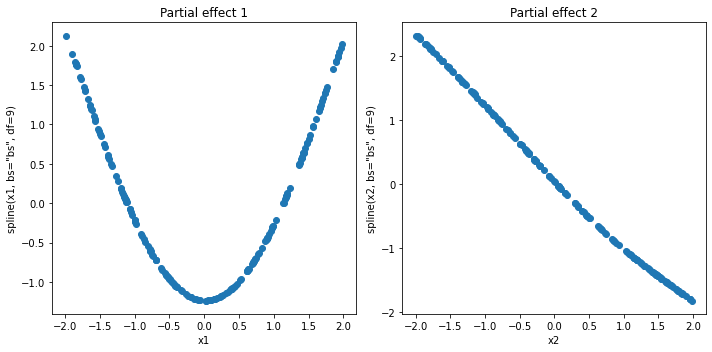

In [10]:
_, partial_effects_loaded = pred_sddr.predict(test_data, clipping=True, plot=True)

### Predicted Distribution

To get the distribution simply call:

In [13]:
distribution_layer = pred_sddr.get_distribution()

/Users/christina.bukas/opt/anaconda3/envs/dev_pysddr/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


From there we can retrieve many of the distribution's properties. See some examples here:

In [14]:
mean = distribution_layer.mean
std = distribution_layer.stddev

/Users/christina.bukas/opt/anaconda3/envs/dev_pysddr/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Second use case: GAMLSS - Logistic Distribution

In this example the input data follows a logistic distribution. Therefore, here we have two distributional parameters, which means that two fomulas need to be defined (which in turn means two SDDRFormulaNets will be created). Additinaly degrees of freedom for the regularization of the loss need to be given for each distributional parameter

### User inputs 

Once again first the user defines the data to be used. Note that this time we are not pre-loading the data as a pandas dataframe by will give the framework directly the data paths:

In [2]:
data_path = '../data/gamlss/X.csv'
target_path = '../data/gamlss/Y.csv'

Next the distribution, formulas and training parameters are defined. Note that PySDDR also support batching: in this example a batch size smaller than the size of the data is defined.

In [3]:
distribution  = 'Logistic'

formulas = {'loc': '~1+spline(x1, bs="bs", df=4)+spline(x2, bs="bs",df=4) + d1(x1)+d2(x2)',
            'scale': '~1 + spline(x3, bs="bs",df=4) + spline(x4, bs="bs",df=4)'
            }

deep_models_dict = {
'd1': {
    'model': nn.Sequential(nn.Linear(1,15)),
    'output_shape': 15},
'd2': {
    'model': nn.Sequential(nn.Linear(1,3),nn.ReLU(), nn.Linear(3,8)),
    'output_shape': 8}
}

train_parameters = {
    'batch_size': 100,
    'epochs': 500,
    'degrees_of_freedom': {'loc':4, 'scale':4},
    'optimizer' : optim.RMSprop
}

### Initialization

The sddr instance is initialized with the parameters given by the user in the previous step. This time we do not specify an output directory which means all outputs will be stored in the current working directory.

In [4]:
sddr = Sddr(distribution=distribution,
            formulas=formulas,
            deep_models_dict=deep_models_dict,
            train_parameters=train_parameters)

Using device:  cpu


### Training

Again in this example we train our network with our training data


/Users/christina.bukas/Documents/AI_projects/code/reimplementations/PySDDR/sddr/utils/utils.py:174: UserWarning: df too large: Degrees of freedom (df = 4) cannot be larger than the rank of the design matrix (rank = 4). Unpenalized base-learner with df = 4 will be used. Re-consider model specification.
  warnings.warn("""df too large: Degrees of freedom (df = {0}) cannot be larger than the rank of the design matrix (rank = {1}). Unpenalized base-learner with df = {1} will be used. Re-consider model specification.""".format(df,rank_dm))
/Users/christina.bukas/Documents/AI_projects/code/reimplementations/PySDDR/sddr/utils/utils.py:174: UserWarning: df too large: Degrees of freedom (df = 4) cannot be larger than the rank of the design matrix (rank = 4). Unpenalized base-learner with df = 4 will be used. Re-consider model specification.
  warnings.warn("""df too large: Degrees of freedom (df = {0}) cannot be larger than the rank of the design matrix (rank = {1}). Unpenalized base-learner wi

Beginning training ...
Train Epoch: 0 	 Loss: 2.589325
Train Epoch: 50 	 Loss: 2.298525
Train Epoch: 100 	 Loss: 2.294645
Train Epoch: 150 	 Loss: 2.294619
Train Epoch: 200 	 Loss: 2.294610
Train Epoch: 250 	 Loss: 2.294602
Train Epoch: 300 	 Loss: 2.294585
Train Epoch: 350 	 Loss: 2.294590
Train Epoch: 400 	 Loss: 2.294591
Train Epoch: 450 	 Loss: 2.294570


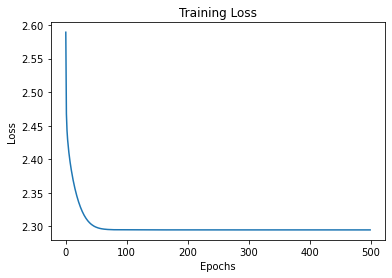

In [5]:
#instead of giving a data and target as data frames, here we give the path and the data is loaded automatically
sddr.train(structured_data=data_path,
           target=target_path,
           plot=True)

### Visualizing the partial effects

In this case the model is a generalized additive model with:

* two splines: one has a quadratic effect, one has only a linear effect for the mean ('loc') parameter 
* two splines: one has only a linear effect with slope 0.5, one has the form sin(4*x)) for the scale parameter.

 These effects are confirmed when plotting the partial effects below.

/Users/christina.bukas/opt/anaconda3/envs/dev_pysddr/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


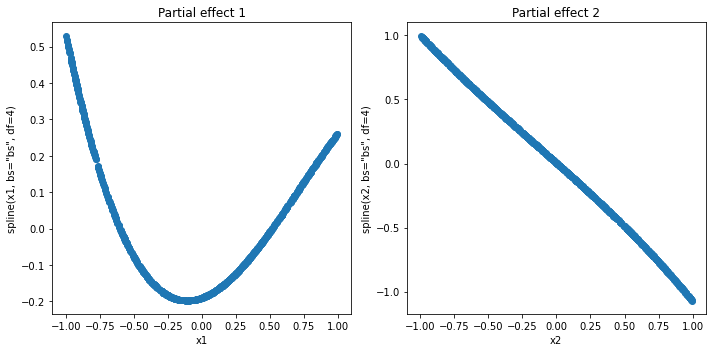

In [6]:
partial_effects_loc = sddr.eval('loc')

/Users/christina.bukas/opt/anaconda3/envs/dev_pysddr/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


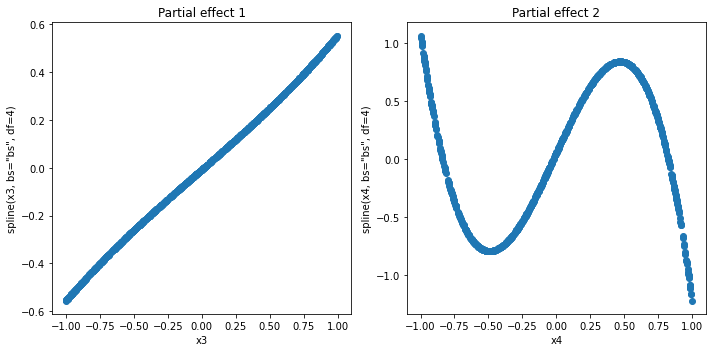

In [7]:
partial_effects_scale = sddr.eval('scale')

### Orthogonalization

As explained in the read me the model in pysddr has two orthogonalization steps that work in a similar manner: 

1. Orthogonalization between linear and smooth terms to remove any linear effects from smooth terms and leave only non-linear features (performed during pre-processing) and
2. Orthogonalization between smooth terms and unstructured outputs to remove any effects from smooth terms in unstructured part (performed during every forward pass of the network)

To visualize the effect of orthogonalization, in the example below we change the formulas from above and add the linear feature x3 to the linear part of the scale formula. We then re-train our model based on teh new formula and visualize the partial effects.

/Users/christina.bukas/opt/anaconda3/envs/dev_pysddr/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/christina.bukas/Documents/AI_projects/code/reimplementations/PySDDR/sddr/utils/utils.py:174: UserWarning: df too large: Degrees of freedom (df = 4) cannot be larger than the rank of the design matrix (rank = 4). Unpenalized base-learner with df = 4 will be used. Re-consider model specification.
  warnings.warn("""df too large: Degrees of freedom (df = {0}) cannot be larger than the rank of the design matrix (rank = {1}). Unpenalized base-learner with df = {1} will be used. Re-consider model specification.""".format(df,rank_dm))
/Users/christina.bukas/Documents/AI_projects/code/reimplementat

Using device:  cpu
Beginning training ...
Train Epoch: 0 	 Loss: 2.627401
Train Epoch: 50 	 Loss: 2.300044
Train Epoch: 100 	 Loss: 2.294849
Train Epoch: 150 	 Loss: 2.294805
Train Epoch: 200 	 Loss: 2.294802
Train Epoch: 250 	 Loss: 2.294800
Train Epoch: 300 	 Loss: 2.294799
Train Epoch: 350 	 Loss: 2.294795
Train Epoch: 400 	 Loss: 2.294796
Train Epoch: 450 	 Loss: 2.294796


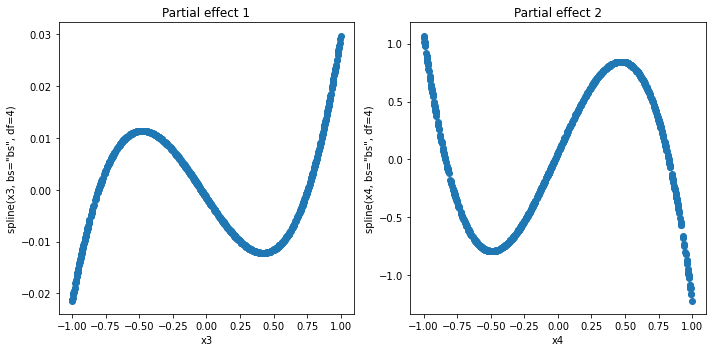

In [9]:
formulas = {'loc': '~1+spline(x1, bs="bs", df=4)+spline(x2, bs="bs",df=4) + d1(x1)+d2(x2)',
            'scale': '~x3 + spline(x3, bs="bs",df=4) + spline(x4, bs="bs",df=4)'
            }
sddr = Sddr(distribution=distribution,
            formulas=formulas,
            deep_models_dict=deep_models_dict,
            train_parameters=train_parameters)

sddr.train(structured_data=data_path,
           target=target_path)

partial_effects_scale = sddr.eval('scale')

As expected the orthogonalization has removed the effect of feature x3 (Partial effect 1) from the smooth terms as it is a linear feature which can be fully represented by the linear part of the network. The values in the y -axis are so small resulting in this partial effect actually having little or no effect.